## Lab01 
MLP实现对手写数字集的训练，自己设计Hidden layer
*`Created by Liu`*

## Step 1.
- 下载数据集
- *`Created by Liu`*

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

# 定义数据的预处理操作：转换为Tensor并标准化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST 数据的均值和标准差
])

# 下载并加载 MNIST 训练集
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 下载并加载 MNIST 测试集
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 使用 DataLoader 进行批量处理
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# 验证数据加载
for images, labels in trainloader:
    print(f"Images batch shape: {images.size()}")
    print(f"Labels batch shape: {labels.size()}")
    break

Images batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


In [11]:
import os
print(os.getcwd())

D:\machine_learning\DeepL\Lab


## Step 2.
- 注意`data`的路径设置, 方便模型数据使用。
- 以下为代码示例，采用MNIST手写数据集。
- *`Created by Liu`*

Using device: cuda
Epoch [1/5], Loss: 1.4893
Epoch [2/5], Loss: 1.4624
Epoch [3/5], Loss: 1.5230
Epoch [4/5], Loss: 1.5070
Epoch [5/5], Loss: 1.4620


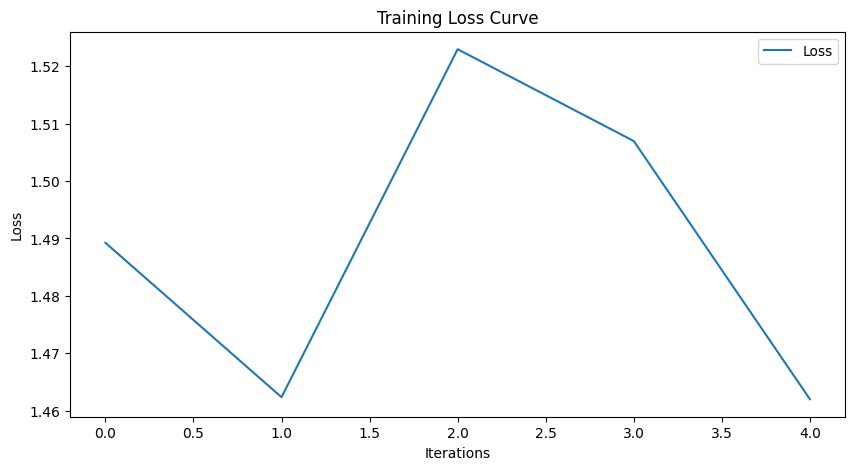

Test Accuracy: 96.86%


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
seed = 43
random.seed(seed)
torch.manual_seed(seed)

# 定义超参数
input_size = 28 * 28  # 输入层尺寸：MNIST图像是28x28像素
hidden_size1 = 128     # 隐藏层神经元数量
output_size = 10      # 输出层神经元数量（对应0到9共10类）
num_epochs = 5        # 训练轮数
batch_size = 100       # 每个批次的样本数量
learning_rate = 0.001 # 学习率

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

data_dir = './data'
train_dataset = torchvision.datasets.MNIST(root=data_dir, train=True, download=False, transform=transform)
test_dataset = torchvision.datasets.MNIST(root=data_dir, train=False, download=False, transform=transform)
# 创建数据加载器
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)  # 第一隐藏层
        self.relu1 = nn.ReLU()                          # ReLU激活函数                    # 第二隐藏层的激活函数
        self.fc2 = nn.Linear(hidden_size1, output_size)  # 输出层

    def forward(self, x):
        x = x.view(-1, input_size)  # 将图像展平成一维向量
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return nn.functional.softmax(x, dim=1)  # 应用softmax


# 初始化模型、损失函数和优化器
model = MLP(input_size, hidden_size1, output_size).to(device)
criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
losses = []
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # 前向传播
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    losses.append(loss.item())

plt.figure(figsize=(10, 5))
plt.plot(range(len(losses)), losses, label='Loss')
plt.title('Training Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 测试模型
model.eval()  # 将模型设为评估模式
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

In [7]:
# 获取所有训练集标签的唯一值
unique_labels = train_dataset.targets.unique()
print("Unique labels in the training dataset:", unique_labels)
print("Number of unique labels:", len(unique_labels))

Unique labels in the training dataset: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Number of unique labels: 10


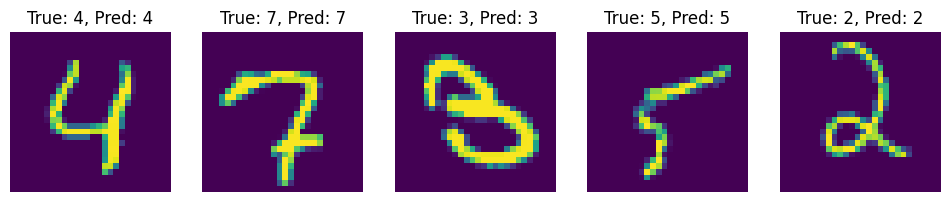

In [21]:
n = 5
# 随机选择 n 张图片
images, labels = next(iter(test_loader))  # 从 DataLoader 中取出一批数据
indices = random.sample(range(len(images)), n)  # 随机选择索引
selected_images = images[indices].to(device)  # 选择图片并移动到设备
selected_labels = labels[indices]  # 对应标签

# 进行预测
model.eval()  # 设置模型为评估模式
with torch.no_grad():
    outputs = model(selected_images)
    _, predicted = torch.max(outputs, 1)  # 预测类别

# 绘制结果
plt.figure(figsize=(12, 8))
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(selected_images[i].cpu().numpy().transpose(1, 2, 0))  # 转换为 HWC 格式
    plt.title(f'True: {selected_labels[i].item()}, Pred: {predicted[i].item()}')
    plt.axis('off')  # 关闭坐标轴

plt.show()


## Step3.
>LeNet-5神经网络
>
**LeNet-5 结构**
- 输入层：32x32 像素的灰度图像（通常用于 MNIST 数据集）。
- 卷积层 1 (C1)：6 个 5x5 的卷积核，输出 28x28 的特征图。
- 激活函数 1 (T1)：Tanh 激活函数。
- 池化层 1 (S2)：2x2 的平均池化，输出 14x14 的特征图。
- 卷积层 2 (C3)：16 个 5x5 的卷积核，输出 10x10 的特征图。
- 激活函数 2 (T2)：Tanh 激活函数。
- 池化层 2 (S4)：2x2 的平均池化，输出 5x5 的特征图。
- 卷积层 3 (C5)：120 个 5x5 的卷积核，输出 1x1 的特征图。
- 全连接层 1 (F6)：84 个神经元。
- 输出层：10 个神经元（分类为 0-9）。
- *`Created by Liu`*

Epoch [1/5], Loss: 0.1349
Epoch [2/5], Loss: 0.2373
Epoch [3/5], Loss: 0.0292
Epoch [4/5], Loss: 0.0028
Epoch [5/5], Loss: 0.0134


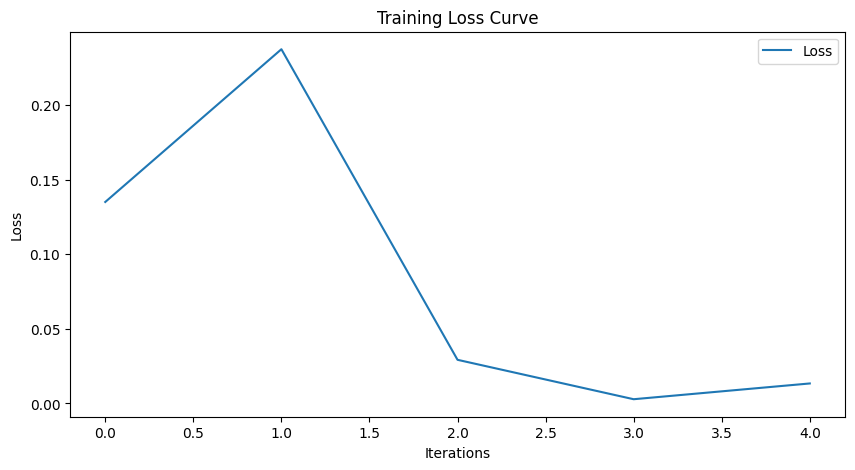

Test Loss: 0.0462, Test Accuracy: 98.54%


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as DataLoader
import matplotlib.pyplot as plt
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 超参数
batch_size = 64
learning_rate = 0.001
num_epochs = 5

# 数据加载
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # LeNet-5 输入大小为32x32
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# 定义 LeNet-5 模型
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.act1 = nn.Tanh()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.act2 = nn.Tanh()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.act3 = nn.Tanh()

        self.fc1 = nn.Linear(120, 84)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.act3(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.act4(self.fc1(x))
        x = self.fc2(x)
        return x

# 初始化模型并移动到设备
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []
# 训练模型
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # 移动到设备
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.figure(figsize=(10, 5))
plt.plot(range(len(losses)), losses, label='Loss')
plt.title('Training Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 模型评估
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # 移动到设备
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

average_loss = test_loss / len(test_loader)
accuracy = correct / total * 100

print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.2f}%')


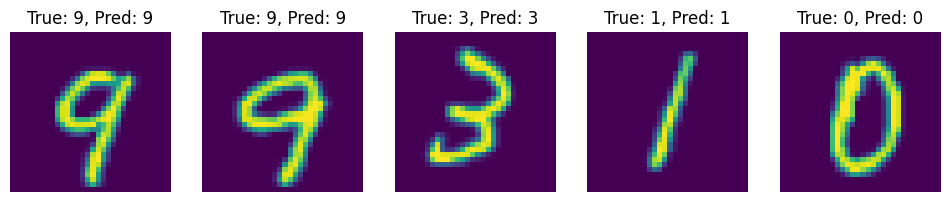

In [24]:
n = 5
# 随机选择 n 张图片
images, labels = next(iter(test_loader))  # 从 DataLoader 中取出一批数据
indices = random.sample(range(len(images)), n)  # 随机选择索引
selected_images = images[indices].to(device)  # 选择图片并移动到设备
selected_labels = labels[indices]  # 对应标签

# 进行预测
model.eval()  # 设置模型为评估模式
with torch.no_grad():
    outputs = model(selected_images)
    _, predicted = torch.max(outputs, 1)  # 预测类别

# 绘制结果
plt.figure(figsize=(12, 8))
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(selected_images[i].cpu().numpy().transpose(1, 2, 0))  # 转换为 HWC 格式
    plt.title(f'True: {selected_labels[i].item()}, Pred: {predicted[i].item()}')
    plt.axis('off')  # 关闭坐标轴

plt.show()


## Step4.
> 设计你的神经网络 `MLP`or`CNN`对你感兴趣的数据集进行训练并预

*`Created by Liu`*

> 收集自网络的海绵宝宝人物图片数据, 进行统一格式处理。

In [3]:
import os
from PIL import Image

# 设置目标文件夹路径和统一尺寸
base_folder = r'D:\machine_learning\DeepL\Lab\data\SpongeBob SquarePants'
target_size = (128, 128)  # 统一尺寸

for subfolder in os.listdir(base_folder):
    subfolder_path = os.path.join(base_folder, subfolder)
    if os.path.isdir(subfolder_path):
        # 遍历子文件夹中的每个图片文件
        count = 0
        for filename in os.listdir(subfolder_path):
            if filename.lower().endswith(('.jpg')):  # 只处理图片
                img_path = os.path.join(subfolder_path, filename)
                # 打开图片并调整尺寸
                img = Image.open(img_path)
                img = img.resize(target_size, Image.LANCZOS) # 调整图片尺寸时使用抗锯齿算法
                
                count += 1 # 计数
                
                # 构造新文件名
                new_filename = f"{subfolder}{count}.jpg"  # 修改扩展名为需要的格式
                new_path = os.path.join(subfolder_path, new_filename)
                
                # 保存调整后的图片
                img.save(new_path)
                print(f"Saved: {new_path}")


Saved: D:\machine_learning\DeepL\Lab\data\SpongeBob SquarePants\Aunt Puff\Aunt Puff1.jpg
Saved: D:\machine_learning\DeepL\Lab\data\SpongeBob SquarePants\Aunt Puff\Aunt Puff2.jpg
Saved: D:\machine_learning\DeepL\Lab\data\SpongeBob SquarePants\Aunt Puff\Aunt Puff3.jpg
Saved: D:\machine_learning\DeepL\Lab\data\SpongeBob SquarePants\Aunt Puff\Aunt Puff4.jpg
Saved: D:\machine_learning\DeepL\Lab\data\SpongeBob SquarePants\Aunt Puff\Aunt Puff5.jpg
Saved: D:\machine_learning\DeepL\Lab\data\SpongeBob SquarePants\Aunt Puff\Aunt Puff6.jpg
Saved: D:\machine_learning\DeepL\Lab\data\SpongeBob SquarePants\Aunt Puff\Aunt Puff7.jpg
Saved: D:\machine_learning\DeepL\Lab\data\SpongeBob SquarePants\Aunt Puff\Aunt Puff8.jpg
Saved: D:\machine_learning\DeepL\Lab\data\SpongeBob SquarePants\Aunt Puff\Aunt Puff9.jpg
Saved: D:\machine_learning\DeepL\Lab\data\SpongeBob SquarePants\Aunt Puff\Aunt Puff10.jpg
Saved: D:\machine_learning\DeepL\Lab\data\SpongeBob SquarePants\Mr. Krabs\Mr. Krabs1.jpg
Saved: D:\machine_le


- 参数设置
- 数据格式设置
- 加载训练集
- 模型构建
- 损失函数和优化器选择
- 训练模型
- 可视化模型结果
- 保存模型

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

In [76]:
batch_size = 32
learning_rate = 0.001
num_epochs = 1000

In [77]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [82]:
dataset = datasets.ImageFolder(root=r'D:\machine_learning\DeepL\Lab\data\SpongeBob SquarePants', transform=transform)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
classes = dataset.classes
print("类别:", classes)

类别: ['Aunt Puff', 'Mr. Krabs', 'PaiStart', 'Plankton boss', 'SpongeBob', 'Squidward']


> 具体参数如下定义：

```python
_____________________________________________________________________
> self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
3：输入通道数（channels），对于彩色图像（RGB），通常为 3。灰度图像则为 1。
32：输出通道数（filters），表示该卷积层会生成 32 个特征图（feature maps）。
kernel_size=3：卷积核的大小，这里是 3x3 的卷积核。卷积核的大小决定了在图像上滑动时每次处理的区域。
stride=1：步幅，表示卷积核每次移动的像素数。步幅为 1 表示卷积核每次移动 1 像素。
padding=1：填充，表示在输入图像的边缘添加的像素数。填充为 1 意味着在每一边添加 1 像素，以保持输出特征图的尺寸。
______________________________________________________________________
> self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
kernel_size=2：池化窗口的大小，这里是 2x2 的池化窗口。它决定了在每个窗口内选取最大值的区域。
stride=2：步幅，表示池化窗口每次移动的像素数。步幅为 2 意味着窗口每次移动 2 像素。
padding=0：填充，表示在输入特征图的边缘添加的像素数。填充为 0 表示不添加任何填充。
______________________________________________________________________
> self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
32：输入通道数（channels），表示这一层接收来自前一层的 32 个特征图。前一层的输出通道数就是当前层的输入通道数。
64：输出通道数（filters），表示这一层会生成 64 个特征图。这意味着该层将学习到更多的特征。
kernel_size=3：卷积核的大小，3x3 的卷积核用于处理特征图。
stride=1：步幅，卷积核每次移动 1 个像素。
padding=1：填充，在特征图的边缘添加 1 个像素，以保持特征图尺寸。
______________________________________________________________________
```


In [83]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)  # 根据特征图尺寸调整
        self.fc2 = nn.Linear(128, len(dataset.classes))  # 类别数

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # 展平
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [84]:
model = CNN().to('cuda')  # 使用GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam一般是最好的

In [85]:
losses = []
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to('cuda'), labels.to('cuda')  # 将数据移动到 GPU
        optimizer.zero_grad()  # 清除梯度
        outputs = model(images)  # 前向传播
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
    losses.append(loss.item())
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/1000], Loss: 2.1587
Epoch [100/1000], Loss: 0.0000
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000


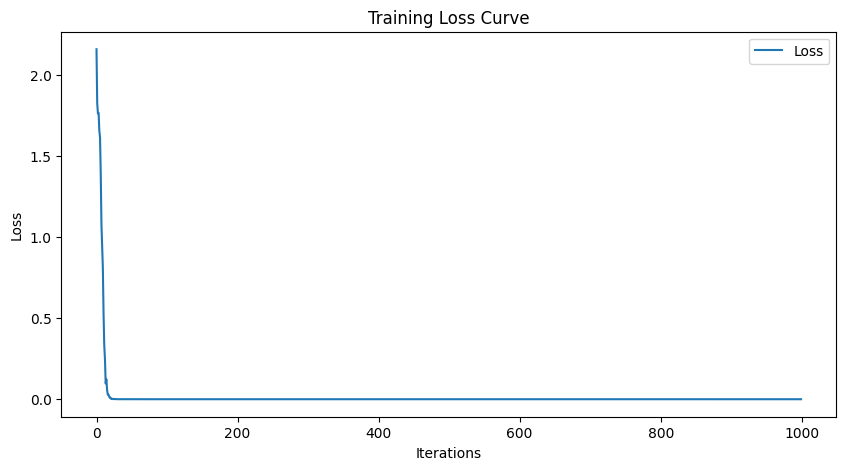

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(len(losses)), losses, label='Loss')
plt.title('Training Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [87]:
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to('cuda'), labels.to('cuda')  # 移动到设备
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

average_loss = test_loss / len(test_loader)
accuracy = correct / total * 100

print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.2f}%')


Test Loss: 0.1316, Test Accuracy: 100.00%


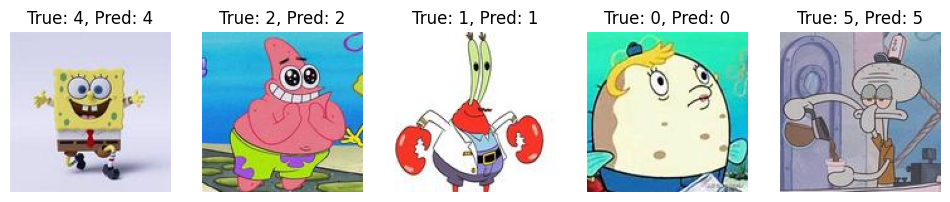

In [88]:
import random
n = 5
images, labels = next(iter(test_loader))  # 从 DataLoader 中取出一批数据
indices = random.sample(range(len(images)), n)  # 随机选择索引
selected_images = images[indices].to('cuda')  # 选择图片并移动到设备
selected_labels = labels[indices]  # 对应标签

# 进行预测
model.eval()  # 设置模型为评估模式
with torch.no_grad():
    outputs = model(selected_images)
    _, predicted = torch.max(outputs, 1)  # 预测类别

# 绘制结果
plt.figure(figsize=(12, 8))
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(selected_images[i].cpu().numpy().transpose(1, 2, 0))  # 转换为 HWC 格式
    plt.title(f'True: {selected_labels[i].item()}, Pred: {predicted[i].item()}')
    plt.axis('off')  # 关闭坐标轴

plt.show()

In [49]:
classes = dataset.classes
print("类别:", classes)

类别: ['Aunt Puff', 'Mr. Krabs', 'PaiStart', 'Plankton boss', 'SpongeBob', 'Squidward']


*Created by Liu `2024/10/22`*